In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %cd /content/drive/MyDrive/Colab Notebooks/HGCAL/visual-inspection/autoencoder

/content/drive/MyDrive/Colab Notebooks/HGCAL/visual-inspection/autoencoder


In [3]:
# Import necessary libraries
import os
import sys

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Directory path used in Google Colab
# project_dir = '/content/drive/MyDrive/Colab Notebooks/HGCAL/visual-inspection'

# Directory path used in local
project_dir = '../'
autoencoder_dir = os.path.join(project_dir, 'autoencoder')

sys.path.append(project_dir)
sys.path.append(autoencoder_dir)

from data_loading import *
from training import *

# Set the seed
torch.manual_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Path to the datasets folder
DATASET_PATH = os.path.join(project_dir, 'datasets')
CHECKPOINT_PATH = os.path.join(autoencoder_dir, 'small_ae.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Read in the image
image = Image.open(os.path.join(DATASET_PATH, 'unperturbed_images', 'hexaboard_1.png'))

# Get the height and width of the image
width, height = image.size
print('Image width:', width)
print('Image height:', height)

Image width: 1434
Image height: 1248


- The code block below saves segments from the perturbed images to a folder, then removes the transparency channel from all segments.

In [5]:
# # Adjust the number of segments
# NUM_VERTICAL_SEGMENTS = 20
# NUM_HORIZONTAL_SEGMENTS = 12

# # Define the transformations
# transform = transforms.Compose([
#     RotationAndSegmentationTransform(
#         height=height,
#         width=width,
#         vertical_segments=NUM_VERTICAL_SEGMENTS,
#         horizontal_segments=NUM_HORIZONTAL_SEGMENTS
#     ),
#     # transforms.RandomRotation(degrees=2),
#     # transforms.RandomHorizontalFlip(),
#     # transforms.RandomVerticalFlip(),
# ])

# # Read in and process the iamges
# perturbed_dataset = HexaboardDataset(
#     image_dir=os.path.join(DATASET_PATH, 'perturbed_images'),
#     transform=transform
# )

# # Set the batch and chunk size
# batch_size = 1
# chunk_size = 12

# # Create data loaders
# perturbed_image_loader = DataLoader(perturbed_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# # Save the segments to a folder to synthesize perturbed data
# data_iter = next(iter(perturbed_image_loader)).squeeze(0)
# # print(data_iter.shape)

# for i, image in enumerate(data_iter):
#     image = image.squeeze(0).moveaxis(0,2).numpy() * 255
#     image = Image.fromarray(np.asarray(np.clip(image, 0, 255), dtype="uint8"))
#     image.save(os.path.join(DATASET_PATH, 'perturbed_segments', f'bad_segment_{i + 1}.png'))

# # Function to remove the transparency channel
# def remove_transparency(
#     image_dir: str,
# ):
#     image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

#     for image_path in image_paths:
#         img = Image.open(image_path)
#         img = np.array(img)
#         img = img[:, :, 0:3]
#         img = Image.fromarray(img)
#         img.save(image_path)

# remove_transparency(os.path.join(DATASET_PATH, 'perturbed_segments'))

In [6]:
# Adjust the number of segments
NUM_VERTICAL_SEGMENTS = 20
NUM_HORIZONTAL_SEGMENTS = 12

# Define the transformations
transform = transforms.Compose([
    RotationAndSegmentationTransform(
        height=height,
        width=width,
        vertical_segments=NUM_VERTICAL_SEGMENTS,
        horizontal_segments=NUM_HORIZONTAL_SEGMENTS
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Read in and process the images
train_dataset = HexaboardDataset(
    image_dir=os.path.join(DATASET_PATH, 'unperturbed_images'),
    transform=transform
)
val_dataset = HexaboardDataset(
    image_dir=os.path.join(DATASET_PATH, 'perturbed_segments'),
    transform=transforms.Compose([transforms.ToTensor()])
)

# Set the batch and chunk size
batch_size = 1
chunk_size = 12

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Print some information about the data
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
# print(f'Test dataset size: {len(test_dataset)}')
print(f'Segments Shape: {val_dataset[0].shape}')
print(f'Image shape: {val_dataset[0][0].shape}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 1
Validation dataset size: 16
Segments Shape: torch.Size([3, 62, 59])
Image shape: torch.Size([62, 59])
Image tensor type: torch.float32
Batches: 1


In [7]:
# Get the segments' height and width
segment_height = train_dataset[0][0][0].shape[0]
segment_width = train_dataset[0][0][0].shape[1]
print('Segment height:', segment_height)
print('Segment width:', segment_width)

Segment height: 62
Segment width: 59


In [8]:
# Initialize the model
cnn_ae = SimpleCNNAutoEncoder(
    height=segment_height,
    width=segment_width,
    latent_dim=128,
    kernel_sizes=[64, 128]
)
cnn_ae.to(device)

SimpleCNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
  )
  (padding): ZeroPad2d((0, 0, 0, 3))
  (bottleneck): Linear(in_features=26880, out_features=128, bias=True)
  (unbottleneck): Linear(in_features=128, out_features=26880, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2))
  )
)

In [9]:
optimizer = optim.Adam(cnn_ae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.BCEWithLogitsLoss()

# Train the model
history, cnn_ae = train_autoencoder(
    model=cnn_ae,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=scheduler,
    num_epochs=500,
    save_path=CHECKPOINT_PATH
)

Epoch [1/500], Train Loss: 0.6338, Val Loss: 0.6364, LR: [0.001]
Epoch [2/500], Train Loss: 0.5420, Val Loss: 0.5896, LR: [0.00099]
Epoch [3/500], Train Loss: 0.5236, Val Loss: 0.5798, LR: [0.0009801]
Epoch [4/500], Train Loss: 0.5103, Val Loss: 0.5645, LR: [0.000970299]
Epoch [5/500], Train Loss: 0.5001, Val Loss: 0.5527, LR: [0.0009605960099999999]
Epoch [6/500], Train Loss: 0.4910, Val Loss: 0.5388, LR: [0.0009509900498999999]
Epoch [7/500], Train Loss: 0.4858, Val Loss: 0.5334, LR: [0.0009414801494009999]
Epoch [8/500], Train Loss: 0.4831, Val Loss: 0.5288, LR: [0.0009320653479069899]
Epoch [9/500], Train Loss: 0.4803, Val Loss: 0.5238, LR: [0.00092274469442792]
Epoch [10/500], Train Loss: 0.4777, Val Loss: 0.5196, LR: [0.0009135172474836408]
Epoch [11/500], Train Loss: 0.4759, Val Loss: 0.5173, LR: [0.0009043820750088043]
Epoch [12/500], Train Loss: 0.4743, Val Loss: 0.5143, LR: [0.0008953382542587163]
Epoch [13/500], Train Loss: 0.4728, Val Loss: 0.5119, LR: [0.000886384871716129

In [14]:
# Save the model again (just to be sure)
torch.save(cnn_ae.state_dict(), CHECKPOINT_PATH)

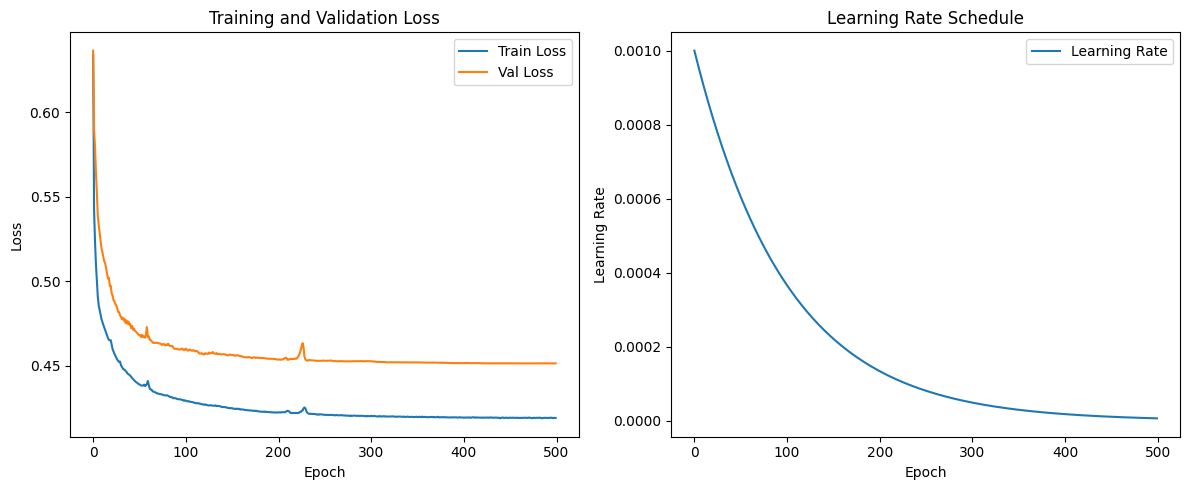

In [15]:
# View the training progress
plot_metrics(history)

In [16]:
# Load the model's weights
cnn_ae.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True))

<All keys matched successfully>

Train Loss: 0.4194


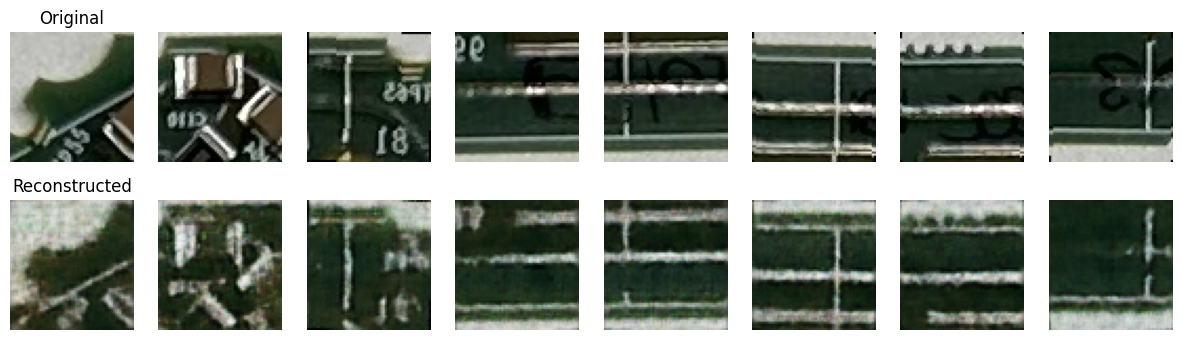

Test Loss: 0.4515


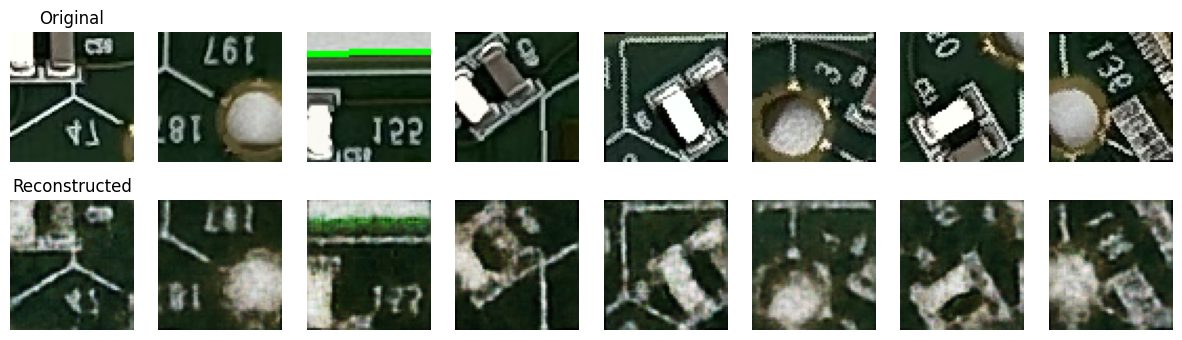

In [17]:
# Evaluate the model on unperturbed vs. perturbed images
criterion = nn.BCEWithLogitsLoss()

evaluate_autoencoder(
    model=cnn_ae,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_images=8,
    visualize=True
)